In [1]:
import os

# Подивимось на структуру папок датасету
data_path = "/kaggle/input"

for dirname, _, filenames in os.walk(data_path):
    # Показуємо тільки назви папок (класи), не всі файли
    level = dirname.replace(data_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(dirname)}/')
    if level >= 2:  # не заглиблюємось далі 2 рівнів
        continue

input/
  datasets/
    sshikamaru/
      fruit-recognition/
        test/
          test/
        train/
          train/
            Orange/
            Tomato/
            Passion Fruit/
            Cucumber Ripe/
            Cactus fruit/
            Pomegranate/
            Plum/
            Pineapple/
            Papaya/
            Potato Red/
            Kiwi/
            Limes/
            Apple Braeburn/
            Pear/
            Onion White/
            Strawberry/
            Grape Blue/
            Blueberry/
            Apple Granny Smith/
            Apricot/
            Pepper Red/
            Clementine/
            Lemon/
            Avocado/
            Raspberry/
            Cantaloupe/
            Peach/
            Corn/
            Banana/
            Cherry/
            Pepper Green/
            Watermelon/
            Mango/


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn

# Трансформації для тренувальних даних (з аугментацією)
# Посилання: https://pytorch.org/vision/stable/transforms.html
# Навіщо це потрібно: нейромережа вчиться краще, коли бачить більше різноманітних прикладів.
# Без аугментації вона може "завчити" конкретні фото замість того,
# щоб зрозуміти загальні ознаки фрукта.
# Аугментація — це коли ти штучно "розмножуєш" свої фотографії, трохи змінюючи кожну.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Шлях до даних (тільки train — там є підпапки з класами)
train_path = "/kaggle/input/datasets/sshikamaru/fruit-recognition/train/train/"

# GPU пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Пристрій: {device}")

Пристрій: cuda


In [3]:
# Розбиття (як на уроці)
# Повний датасет з двома варіантами трансформацій
full_dataset = datasets.ImageFolder(train_path, transform=train_transform)
full_dataset_test = datasets.ImageFolder(train_path, transform=test_transform)

# Фіксуємо seed для однакового розбиття (однаково для PyTorch і TensorFlow!)
torch.manual_seed(42)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Генеруємо індекси один раз для усіх 4 варіантів
indices = torch.randperm(len(full_dataset)).tolist()
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Train — з аугментацією, Test — без аугментації
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset_test, test_indices)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Параметри
input_size = 3 * 224 * 224  # 150528
num_classes = len(full_dataset.classes)

print(f"Тренувальних: {len(train_dataset)}")
print(f"Тестових: {len(test_dataset)}")

# Назви класів (фруктів)
print(f"Кількість класів: {len(full_dataset.classes)}")
print(f"Класи: {full_dataset.classes}")
print(f"\nclass_to_idx: {full_dataset.class_to_idx}")

print(f"Розмір входу: {input_size}")

Тренувальних: 13483
Тестових: 3371
Кількість класів: 33
Класи: ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']

class_to_idx: {'Apple Braeburn': 0, 'Apple Granny Smith': 1, 'Apricot': 2, 'Avocado': 3, 'Banana': 4, 'Blueberry': 5, 'Cactus fruit': 6, 'Cantaloupe': 7, 'Cherry': 8, 'Clementine': 9, 'Corn': 10, 'Cucumber Ripe': 11, 'Grape Blue': 12, 'Kiwi': 13, 'Lemon': 14, 'Limes': 15, 'Mango': 16, 'Onion White': 17, 'Orange': 18, 'Papaya': 19, 'Passion Fruit': 20, 'Peach': 21, 'Pear': 22, 'Pepper Green': 23, 'Pepper Red': 24, 'Pineapple': 25, 'Plum': 26, 'Pomegranate': 27, 'Potato Red': 28, 'Raspberry': 29, 'Strawberry': 30, 'Tom

In [4]:
# Подивимось на перший зразок
img, label = full_dataset[0]
print(f"Тип: {type(img)}")
print(f"Форма тензора: {img.shape}")  # [C, H, W] = [3, 224, 224]
print(f"Мітка (індекс): {label}")
print(f"Назва класу: {full_dataset.classes[label]}")

# Перший зразок з кожного класу (до 5 класів)
shown_classes = set()
for i in range(len(full_dataset)):
    img, label = full_dataset[i]
    if label not in shown_classes:
        print(f"Зразок [{i}]: форма {img.shape}, мітка: {label} → {full_dataset.classes[label]}")
        shown_classes.add(label)
    if len(shown_classes) >= 5:
        break

Тип: <class 'torch.Tensor'>
Форма тензора: torch.Size([3, 224, 224])
Мітка (індекс): 0
Назва класу: Apple Braeburn
Зразок [0]: форма torch.Size([3, 224, 224]), мітка: 0 → Apple Braeburn
Зразок [492]: форма torch.Size([3, 224, 224]), мітка: 1 → Apple Granny Smith
Зразок [984]: форма torch.Size([3, 224, 224]), мітка: 2 → Apricot
Зразок [1476]: форма torch.Size([3, 224, 224]), мітка: 3 → Avocado
Зразок [1903]: форма torch.Size([3, 224, 224]), мітка: 4 → Banana


In [5]:

# Візуалізація - Перевірка
for images, labels in train_loader:
    print(f"Форма батчу зображень: {images.shape}")  # [batch_size, 3, 224, 224]
    print(f"Форма батчу міток: {labels.shape}")       # [batch_size]
    break  # Виводимо тільки перший батч

Форма батчу зображень: torch.Size([32, 3, 224, 224])
Форма батчу міток: torch.Size([32])


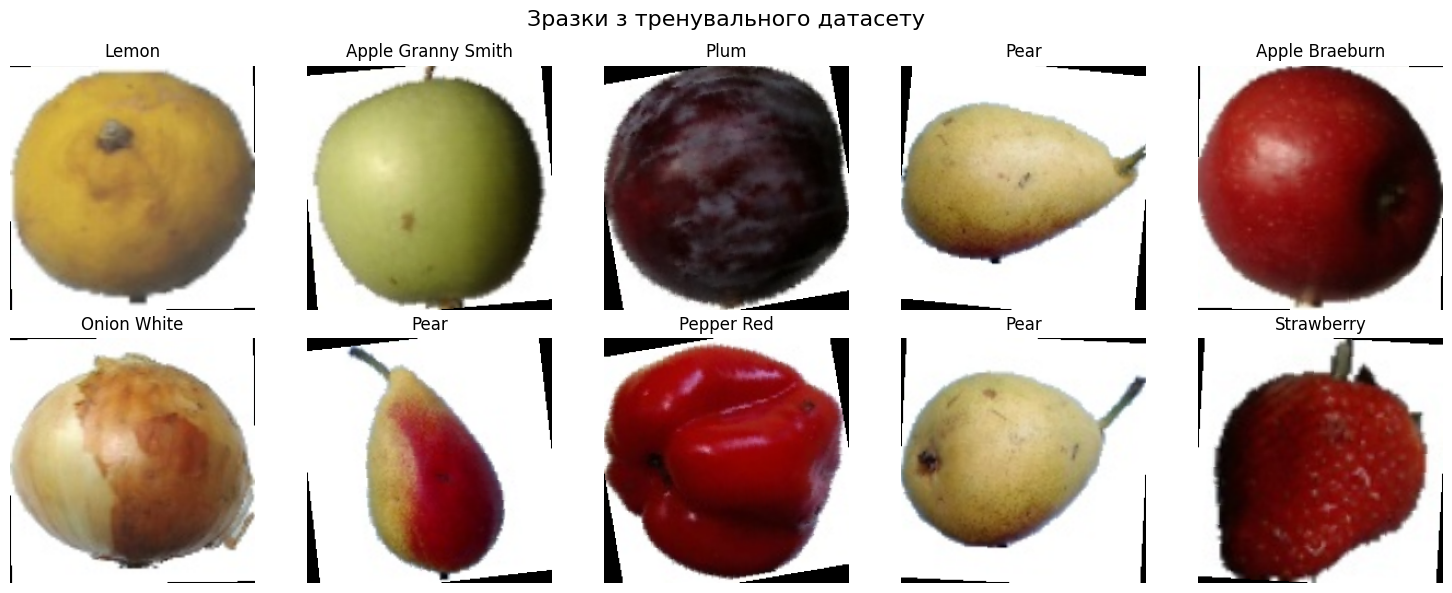

In [6]:
# Візуалізація кількох зразків з тренувального набору
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    # Конвертуємо тензор [C, H, W] → [H, W, C] для matplotlib
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(full_dataset.classes[label])
    ax.axis('off')

plt.suptitle("Зразки з тренувального датасету", fontsize=16)
plt.tight_layout()
plt.show()

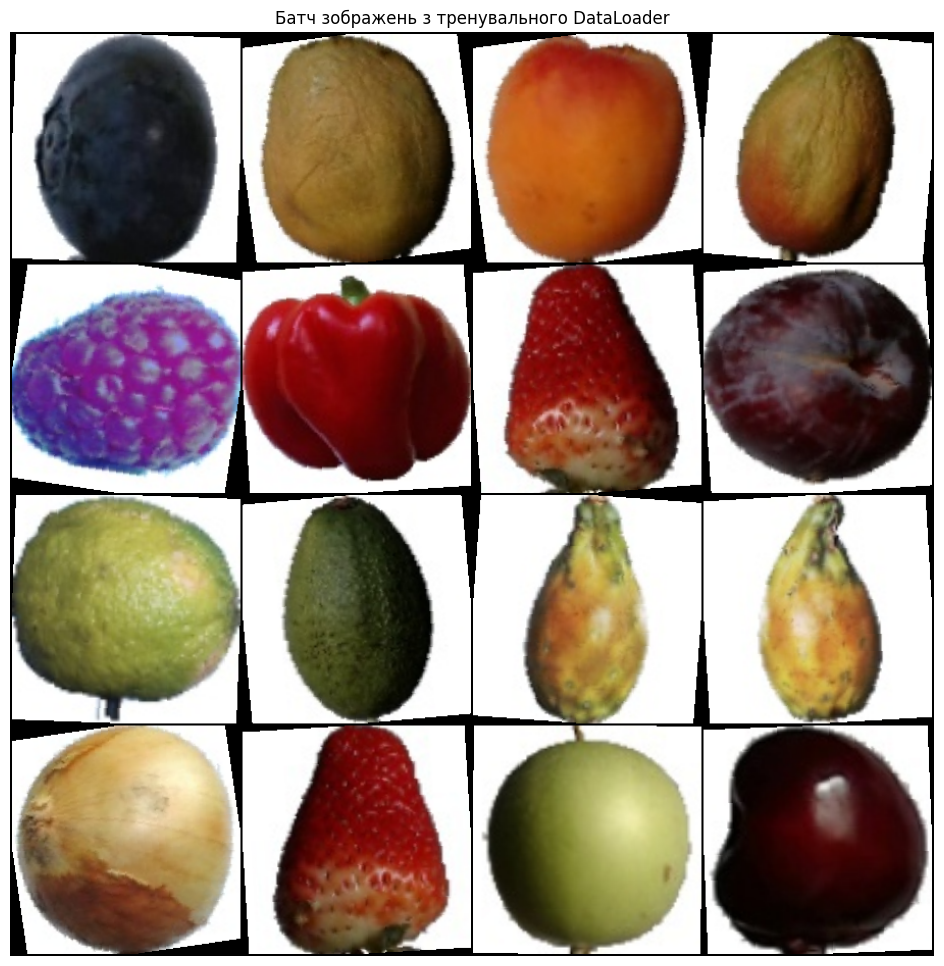

Мітки: ['Blueberry', 'Papaya', 'Apricot', 'Papaya', 'Raspberry', 'Pepper Red', 'Strawberry', 'Plum', 'Limes', 'Avocado', 'Cactus fruit', 'Cactus fruit', 'Onion White', 'Strawberry', 'Apple Granny Smith', 'Cherry']


In [7]:
# Отримуємо один батч
images, labels = next(iter(train_loader))

# Створюємо сітку зображень
grid = make_grid(images[:16], nrow=4, padding=2)

# Відображаємо
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.title("Батч зображень з тренувального DataLoader")
plt.axis('off')
plt.show()

# Виводимо мітки
print("Мітки:", [full_dataset.classes[l] for l in labels[:16].tolist()])

In [8]:
# Fruit Classification — 4 варіанти нейромережі

# Вхід:       3 × 224 × 224 = 150528
# Flatten:    [batch, 150528]
# Linear/Dense 1:  150528 → 512  + activation
# Linear/Dense 2:  512 → 256     + activation
# Linear/Dense 3:  256 → 128     + activation
# Linear/Dense 4:  128 → num_classes (вихід)

# Параметри
input_size = 3 * 224 * 224  # 150528
num_classes = len(full_dataset.classes)

print(f"Тренувальних: {len(train_dataset)}")
print(f"Тестових: {len(test_dataset)}")

# Назви класів (фруктів)
print(f"Кількість класів: {len(full_dataset.classes)}")
print(f"Класи: {full_dataset.classes}")
print(f"\nclass_to_idx: {full_dataset.class_to_idx}")

print(f"Розмір входу: {input_size}")

Тренувальних: 13483
Тестових: 3371
Кількість класів: 33
Класи: ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']

class_to_idx: {'Apple Braeburn': 0, 'Apple Granny Smith': 1, 'Apricot': 2, 'Avocado': 3, 'Banana': 4, 'Blueberry': 5, 'Cactus fruit': 6, 'Cantaloupe': 7, 'Cherry': 8, 'Clementine': 9, 'Corn': 10, 'Cucumber Ripe': 11, 'Grape Blue': 12, 'Kiwi': 13, 'Lemon': 14, 'Limes': 15, 'Mango': 16, 'Onion White': 17, 'Orange': 18, 'Papaya': 19, 'Passion Fruit': 20, 'Peach': 21, 'Pear': 22, 'Pepper Green': 23, 'Pepper Red': 24, 'Pineapple': 25, 'Plum': 26, 'Pomegranate': 27, 'Potato Red': 28, 'Raspberry': 29, 'Strawberry': 30, 'Tom

In [9]:
 # Варіант 1: PyTorch + ReLU

class FruitNet_ReLU(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                         # Шар 1: → [batch, 150528]
            nn.Linear(input_size, 512),            # Шар 2: 150528 → 512
            nn.ReLU(),
            nn.Linear(512, 256),                   # Шар 3: 512 → 256
            nn.ReLU(),
            nn.Linear(256, 128),                   # Шар 4: 256 → 128
            nn.ReLU(),
            nn.Linear(128, num_classes),            # Шар 5: 128 → num_classes
        )

    def forward(self, x):
        return self.model(x)

model_relu = FruitNet_ReLU(input_size, num_classes).to(device)
print("=== PyTorch + ReLU ===")
print(model_relu)

=== PyTorch + ReLU ===
FruitNet_ReLU(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=33, bias=True)
  )
)


In [10]:
 # Варіант 2: PyTorch + LeakyReLU

class FruitNet_LeakyReLU(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                         # Шар 1: → [batch, 150528]
            nn.Linear(input_size, 512),            # Шар 2: 150528 → 512
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),                   # Шар 3: 512 → 256
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 128),                   # Шар 4: 256 → 128
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, num_classes),            # Шар 5: 128 → num_classes
        )

    def forward(self, x):
        return self.model(x)

model_leaky = FruitNet_LeakyReLU(input_size, num_classes).to(device)

print("=== PyTorch + LeakyReLU ===")
print(model_leaky)

=== PyTorch + LeakyReLU ===
FruitNet_LeakyReLU(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=128, out_features=33, bias=True)
  )
)


In [11]:
# Перевірка обох моделей PyTorch

# тут потрібен .to(device)
images, labels = next(iter(train_loader))
images = images.to(device)          # ← бо модель на GPU

output_relu = model_relu(images)     # модель на GPU, дані теж на GPU
output_leaky = model_leaky(images)

print(f"Вхід:             {images.shape}")
print(f"Вихід ReLU:       {output_relu.shape}")
print(f"Вихід LeakyReLU:  {output_leaky.shape}")

# Кількість параметрів
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print(f"\nПараметрів ReLU:      {count_params(model_relu):,}")
print(f"Параметрів LeakyReLU: {count_params(model_leaky):,}")

Вхід:             torch.Size([32, 3, 224, 224])
Вихід ReLU:       torch.Size([32, 33])
Вихід LeakyReLU:  torch.Size([32, 33])

Параметрів ReLU:      77,239,329
Параметрів LeakyReLU: 77,239,329


In [12]:
# TensorFlow / Keras
# Імпорт та дані (TensorFlow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Завантаження з того ж train_path, розбиття 80/20 з seed=42
train_tf = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=42,
)

test_tf = tf.keras.utils.image_dataset_from_directory(
    train_path,          # ← теж train_path!
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=42,
)

# Зберігаємо class_names ДО нормалізації (після .map() вони зникають)
class_names_tf = train_tf.class_names
num_classes_tf = len(class_names_tf)

# Нормалізація [0, 255] → [0, 1]
normalization = layers.Rescaling(1./255)
train_tf = train_tf.map(lambda x, y: (normalization(x), y))
test_tf = test_tf.map(lambda x, y: (normalization(x), y))

# Параметри
input_shape = (224, 224, 3)
print(f"Класи: {class_names_tf}")
print(f"Кількість класів: {num_classes_tf}")

2026-02-21 12:56:56.376078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771678616.553894      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771678616.603804      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771678617.034357      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771678617.034400      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771678617.034403      24 computation_placer.cc:177] computation placer alr

Found 16854 files belonging to 33 classes.
Using 13484 files for training.


I0000 00:00:1771678634.725535      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14839 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 16854 files belonging to 33 classes.
Using 3370 files for validation.
Класи: ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']
Кількість класів: 33


In [13]:
# Варіант 3: TensorFlow + ReLU
# model_tf_relu = keras.Sequential([
#     layers.Flatten(input_shape=input_shape, name='flatten'),      # Шар 1
#     layers.Dense(512, activation='relu', name='dense_1'),          # Шар 2: 150528 → 512
#     layers.Dense(256, activation='relu', name='dense_2'),          # Шар 3: 512 → 256
#     layers.Dense(128, activation='relu', name='dense_3'),          # Шар 4: 256 → 128
#     layers.Dense(num_classes, activation='softmax', name='output') # Шар 5: 128 → num_classes
# ], name='FruitNet_ReLU')

model_tf_relu = keras.Sequential([
    layers.Input(shape=input_shape),                               # ← новий спосіб
    layers.Flatten(name='flatten'),                                # без input_shape
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dense(256, activation='relu', name='dense_2'),
    layers.Dense(128, activation='relu', name='dense_3'),
    layers.Dense(num_classes_tf, activation='softmax', name='output')
], name='FruitNet_ReLU')

model_tf_relu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== TensorFlow + ReLU ===")
model_tf_relu.summary()

=== TensorFlow + ReLU ===


Model: "FruitNet_ReLU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,239,329 (294.64 MB)

 Trainable params: 77,239,329 (294.64 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Варіант 4: TensorFlow + LeakyReLU
# # Старий спосіб:
# model_tf_leaky = keras.Sequential([
#     layers.Flatten(input_shape=input_shape, name='flatten'),
#     layers.Dense(512, name='dense_1'),
#     layers.LeakyReLU(negative_slope=0.01, name='leaky_1'),
#     ...
# ], name='FruitNet_LeakyReLU')

# Новий спосіб:
model_tf_leaky = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(name='flatten'),
    layers.Dense(512, name='dense_1'),
    layers.LeakyReLU(negative_slope=0.01, name='leaky_1'),
    layers.Dense(256, name='dense_2'),
    layers.LeakyReLU(negative_slope=0.01, name='leaky_2'),
    layers.Dense(128, name='dense_3'),
    layers.LeakyReLU(negative_slope=0.01, name='leaky_3'),
    layers.Dense(num_classes_tf, activation='softmax', name='output'),
], name='FruitNet_LeakyReLU')

model_tf_leaky.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== TensorFlow + LeakyReLU ===")
model_tf_leaky.summary()

=== TensorFlow + LeakyReLU ===


Model: "FruitNet_LeakyReLU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_1 (LeakyReLU)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_2 (LeakyReLU)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_3 (LeakyReLU)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,239,329 (294.64 MB)

 Trainable params: 77,239,329 (294.64 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
 # Перевірка обох моделей TensorFlow

for images, labels in train_tf.take(1):
    output_relu = model_tf_relu(images)
    output_leaky = model_tf_leaky(images)

    print(f"Вхід:             {images.shape}")
    print(f"Вихід ReLU:       {output_relu.shape}")
    print(f"Вихід LeakyReLU:  {output_leaky.shape}")

print(f"\nПараметрів ReLU:      {model_tf_relu.count_params():,}")
print(f"Параметрів LeakyReLU: {model_tf_leaky.count_params():,}")

Вхід:             (32, 224, 224, 3)
Вихід ReLU:       (32, 33)
Вихід LeakyReLU:  (32, 33)

Параметрів ReLU:      77,239,329
Параметрів LeakyReLU: 77,239,329


In [16]:
# Тренування PyTorch + ReLU
import time

# Налаштування
criterion = nn.CrossEntropyLoss()
optimizer_relu = torch.optim.Adam(model_relu.parameters(), lr=0.001)
epochs = 10

# Списки для збереження метрик
train_losses_relu = []
train_accs_relu = []

print("=== Тренування: PyTorch + ReLU ===")
start_time = time.time()

for epoch in range(epochs):
    model_relu.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_relu(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer_relu.zero_grad()
        loss.backward()
        optimizer_relu.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses_relu.append(epoch_loss)
    train_accs_relu.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")

relu_time = time.time() - start_time
print(f"\nЧас тренування ReLU: {relu_time:.1f} сек")

=== Тренування: PyTorch + ReLU ===
Epoch [1/10] Loss: 1.3597 Accuracy: 0.6392
Epoch [2/10] Loss: 0.2489 Accuracy: 0.9149
Epoch [3/10] Loss: 0.1795 Accuracy: 0.9426
Epoch [4/10] Loss: 0.1642 Accuracy: 0.9485
Epoch [5/10] Loss: 0.1218 Accuracy: 0.9634
Epoch [6/10] Loss: 0.1047 Accuracy: 0.9653
Epoch [7/10] Loss: 0.1020 Accuracy: 0.9693
Epoch [8/10] Loss: 0.1107 Accuracy: 0.9684
Epoch [9/10] Loss: 0.0613 Accuracy: 0.9809
Epoch [10/10] Loss: 0.1188 Accuracy: 0.9637

Час тренування ReLU: 548.7 сек


###=== Тренування: PyTorch + ReLU ===
    Epoch [1/10] Loss: 1.4112 Accuracy: 0.6381
    Epoch [2/10] Loss: 0.2531 Accuracy: 0.9154
    Epoch [3/10] Loss: 0.1931 Accuracy: 0.9366
    Epoch [4/10] Loss: 0.1199 Accuracy: 0.9601
    Epoch [5/10] Loss: 0.1377 Accuracy: 0.9546
    Epoch [6/10] Loss: 0.1204 Accuracy: 0.9581
    Epoch [7/10] Loss: 0.1243 Accuracy: 0.9617
    Epoch [8/10] Loss: 0.1560 Accuracy: 0.9548
    Epoch [9/10] Loss: 0.0765 Accuracy: 0.9721
    Epoch [10/10] Loss: 0.0549 Accuracy: 0.9822

In [17]:
# Тренування PyTorch + LeakyReLU
optimizer_leaky = torch.optim.Adam(model_leaky.parameters(), lr=0.001)

train_losses_leaky = []
train_accs_leaky = []

print("=== Тренування: PyTorch + LeakyReLU ===")
start_time = time.time()

for epoch in range(epochs):
    model_leaky.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_leaky(images)
        loss = criterion(outputs, labels)

        optimizer_leaky.zero_grad()
        loss.backward()
        optimizer_leaky.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses_leaky.append(epoch_loss)
    train_accs_leaky.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")

leaky_time = time.time() - start_time
print(f"\nЧас тренування LeakyReLU: {leaky_time:.1f} сек")

=== Тренування: PyTorch + LeakyReLU ===
Epoch [1/10] Loss: 1.4676 Accuracy: 0.6179
Epoch [2/10] Loss: 0.2838 Accuracy: 0.9031
Epoch [3/10] Loss: 0.1651 Accuracy: 0.9424
Epoch [4/10] Loss: 0.1547 Accuracy: 0.9476
Epoch [5/10] Loss: 0.1398 Accuracy: 0.9567
Epoch [6/10] Loss: 0.0787 Accuracy: 0.9741
Epoch [7/10] Loss: 0.1523 Accuracy: 0.9552
Epoch [8/10] Loss: 0.1089 Accuracy: 0.9674
Epoch [9/10] Loss: 0.0873 Accuracy: 0.9723
Epoch [10/10] Loss: 0.0848 Accuracy: 0.9744

Час тренування LeakyReLU: 445.9 сек


### === Тренування: PyTorch + LeakyReLU ===
    Epoch [1/10] Loss: 1.5527 Accuracy: 0.6045
    Epoch [2/10] Loss: 0.2844 Accuracy: 0.9034
    Epoch [3/10] Loss: 0.1715 Accuracy: 0.9420
    Epoch [4/10] Loss: 0.2013 Accuracy: 0.9334
    Epoch [5/10] Loss: 0.1400 Accuracy: 0.9559
    Epoch [6/10] Loss: 0.1191 Accuracy: 0.9618
    Epoch [7/10] Loss: 0.1402 Accuracy: 0.9587
    Epoch [8/10] Loss: 0.1171 Accuracy: 0.9640
    Epoch [9/10] Loss: 0.0529 Accuracy: 0.9828
    Epoch [10/10] Loss: 0.1785 Accuracy: 0.9540

    Час тренування LeakyReLU: 408.5 сек

In [18]:
# Тестування PyTorch (обидва варіанти)
def test_pytorch_model(model, test_loader, device, name):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    avg_loss = test_loss / len(test_loader)
    print(f"{name}: Test Loss: {avg_loss:.4f}, Test Accuracy: {acc:.4f} ({correct}/{total})")
    return avg_loss, acc

print("=== Тестування PyTorch ===")
pt_relu_loss, pt_relu_acc = test_pytorch_model(model_relu, test_loader, device, "ReLU")
pt_leaky_loss, pt_leaky_acc = test_pytorch_model(model_leaky, test_loader, device, "LeakyReLU")

=== Тестування PyTorch ===
ReLU: Test Loss: 0.0895, Test Accuracy: 0.9703 (3271/3371)
LeakyReLU: Test Loss: 0.0120, Test Accuracy: 0.9967 (3360/3371)


### === Тестування PyTorch ===
    ReLU: Test Loss: 0.0360, Test Accuracy: 0.9861 (3324/3371)
    LeakyReLU: Test Loss: 0.0306, Test Accuracy: 0.9896 (3336/3371)


=== Мертві нейрони: PyTorch + ReLU ===
  Шар 2: 470/512 мертвих (91.8%)
  Шар 4: 167/256 мертвих (65.2%)
  Шар 6: 50/128 мертвих (39.1%)

=== Мертві нейрони: PyTorch + LeakyReLU ===
  Шар 2: 443/512 мертвих (86.5%)
  Шар 4: 155/256 мертвих (60.5%)
  Шар 6: 47/128 мертвих (36.7%)


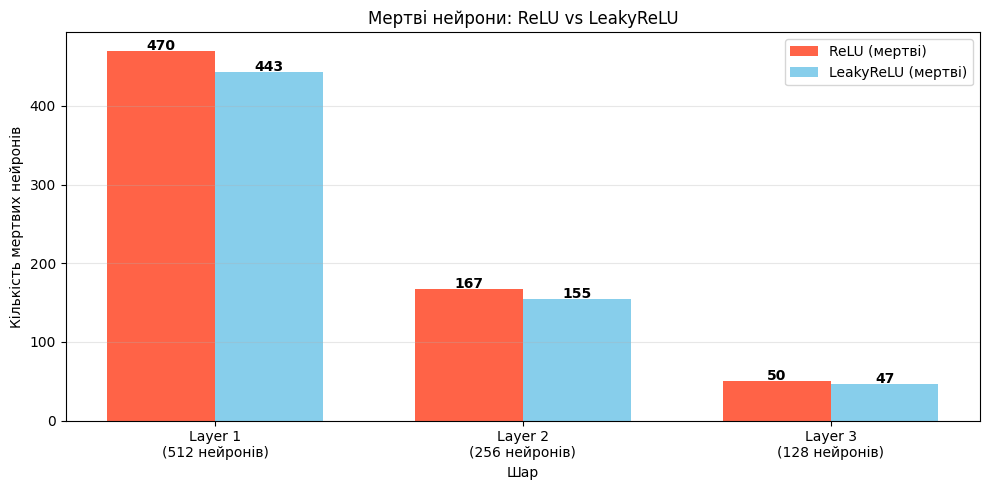

In [19]:
# Аналіз мертвих нейронів
def count_dead_neurons(model, data_loader, device, name):
    """Рахуємо нейрони які видають 0 на ВСІХ зразках"""
    model.eval()
    
    # Збираємо активації після кожного ReLU/LeakyReLU
    activations = {}
    
    def hook_fn(layer_name):
        def hook(module, input, output):
            if layer_name not in activations:
                activations[layer_name] = []
            activations[layer_name].append((output > 0).float().cpu())
        return hook
    
    # Реєструємо hooks на activation шари
    hooks = []
    for layer_name, module in model.model.named_modules():
        if isinstance(module, (nn.ReLU, nn.LeakyReLU)):
            hooks.append(module.register_forward_hook(hook_fn(layer_name)))
    
    # Прогоняємо дані
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            _ = model(images)
    
    # Видаляємо hooks
    for h in hooks:
        h.remove()
    
    # Аналізуємо: нейрон "мертвий" якщо він = 0 для ВСІХ зразків
    print(f"\n=== Мертві нейрони: {name} ===")
    dead_counts = {}
    total_counts = {}
    
    for layer_name, acts in activations.items():
        combined = torch.cat(acts, dim=0)            # [всі зразки, нейрони]
        alive_ratio = combined.mean(dim=0)            # частка активних для кожного нейрона
        dead = (alive_ratio == 0).sum().item()        # нейрон мертвий = 0% активацій
        total = combined.shape[1]
        dead_counts[layer_name] = dead
        total_counts[layer_name] = total
        print(f"  Шар {layer_name}: {dead}/{total} мертвих ({100*dead/total:.1f}%)")
    
    return dead_counts, total_counts

relu_dead, relu_total = count_dead_neurons(model_relu, test_loader, device, "PyTorch + ReLU")
leaky_dead, leaky_total = count_dead_neurons(model_leaky, test_loader, device, "PyTorch + LeakyReLU")

# Графік
fig, ax = plt.subplots(figsize=(10, 5))

layers_names = [f"Layer {i+1}\n({relu_total[k]} нейронів)" for i, k in enumerate(relu_dead.keys())]
x = range(len(layers_names))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], relu_dead.values(), width, label='ReLU (мертві)', color='tomato')
bars2 = ax.bar([i + width/2 for i in x], leaky_dead.values(), width, label='LeakyReLU (мертві)', color='skyblue')

# Підписи на стовпцях
for bar in bars1:
    if bar.get_height() > 0:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
                f'{int(bar.get_height())}', ha='center', fontweight='bold')
for bar in bars2:
    if bar.get_height() > 0:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{int(bar.get_height())}', ha='center', fontweight='bold')

ax.set_xlabel('Шар')
ax.set_ylabel('Кількість мертвих нейронів')
ax.set_title('Мертві нейрони: ReLU vs LeakyReLU')
ax.set_xticks(x)
ax.set_xticklabels(layers_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### === Мертві нейрони: PyTorch + ReLU ===
      Шар 2: 470/512 мертвих (91.8%)
      Шар 4: 179/256 мертвих (69.9%)
      Шар 6: 51/128 мертвих (39.8%)

### === Мертві нейрони: PyTorch + LeakyReLU ===
      Шар 2: 446/512 мертвих (87.1%)
      Шар 4: 152/256 мертвих (59.4%)
      Шар 6: 60/128 мертвих (46.9%)

[https://drive.google.com/file/d/15fZQKqhQ6AOX6v7OaPVYtKuEWx-MOkjp/view?usp=sharing](http://)

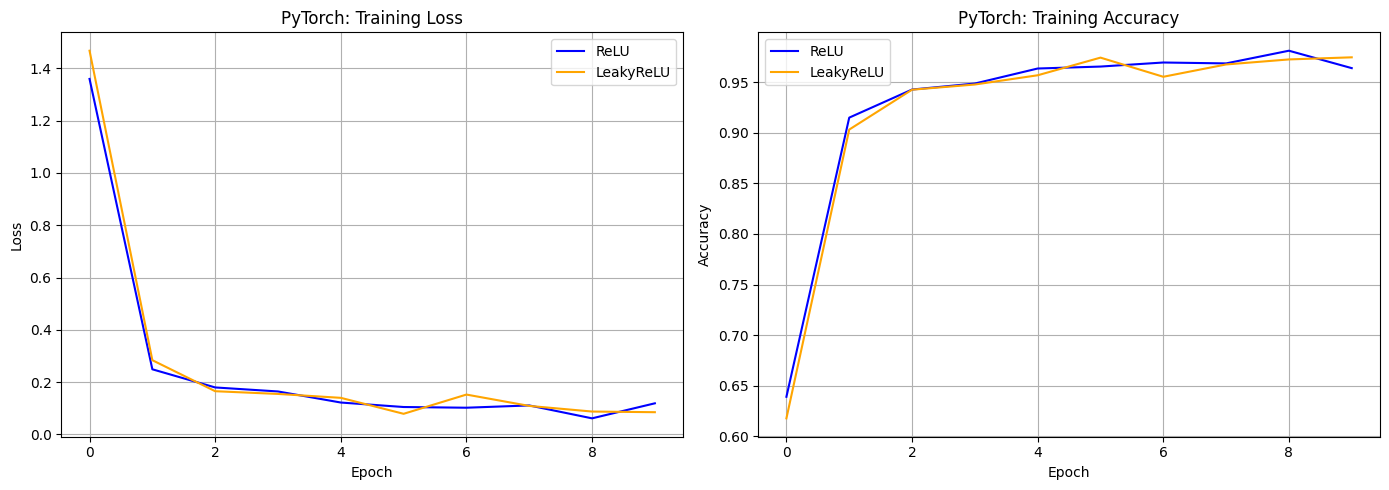

In [20]:
# Графіки PyTorch
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(train_losses_relu, label='ReLU', color='blue')
ax1.plot(train_losses_leaky, label='LeakyReLU', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('PyTorch: Training Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(train_accs_relu, label='ReLU', color='blue')
ax2.plot(train_accs_leaky, label='LeakyReLU', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('PyTorch: Training Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Тренування TensorFlow (обидва варіанти)
# Тренування TensorFlow + ReLU
print("=== Тренування: TensorFlow + ReLU ===")
start_time = time.time()

history_tf_relu = model_tf_relu.fit(
    train_tf,
    validation_data=test_tf,
    epochs=10,
    verbose=1
)

tf_relu_time = time.time() - start_time
print(f"\nЧас тренування TF ReLU: {tf_relu_time:.1f} сек")

=== Тренування: TensorFlow + ReLU ===
Epoch 1/10


I0000 00:00:1771679695.842015      76 service.cc:152] XLA service 0x79b378005ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771679695.842053      76 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771679696.173093      76 cuda_dnn.cc:529] Loaded cuDNN version 91002


 11/422 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0150 - loss: 69.9699

I0000 00:00:1771679697.260789      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.3961 - loss: 15.7029 - val_accuracy: 0.8543 - val_loss: 0.4365
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9280 - loss: 0.2323 - val_accuracy: 0.9668 - val_loss: 0.1059
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9569 - loss: 0.1422 - val_accuracy: 0.9846 - val_loss: 0.0412
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9499 - loss: 0.1783 - val_accuracy: 0.9490 - val_loss: 0.1969
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9419 - loss: 0.2057 - val_accuracy: 0.9525 - val_loss: 0.2044
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9705 - loss: 0.1094 - val_accuracy: 0.9668 - val_loss: 0.1239
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9632 - loss: 0.1496 - val_accuracy: 0.9997 - val_loss: 6.7423e-04
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9833 - loss: 0.0883 - val_ac

422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3874 - loss: 20.4150 - val_accuracy: 0.8973 - val_loss: 0.2825
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9414 - loss: 0.2089 - val_accuracy: 0.8519 - val_loss: 0.4454
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8877 - loss: 0.4225 - val_accuracy: 0.9816 - val_loss: 0.0713
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9679 - loss: 0.1149 - val_accuracy: 0.8697 - val_loss: 0.5246
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9507 - loss: 0.1917 - val_accuracy: 0.9902 - val_loss: 0.0325
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9390 - loss: 0.3049 - val_accuracy: 0.9843 - val_loss: 0.0389
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9570 - loss: 0.1818 - val_accuracy: 0.9929 - val_loss: 0.0248
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9629 - loss: 0.1495 - val_accuracy: 0.9496 - val_loss: 0.1536
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9609 - loss: 0.1721 - val_accuracy: 0.9970 - val_loss: 0.0074
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9920 - loss: 0.0349 - val_accuracy: 0.9680 - val_loss: 0.1169

Час тренування TF ReLU: 98.2 сек

422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3874 - loss: 20.4150 - val_accuracy: 0.8973 - val_loss: 0.2825
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9414 - loss: 0.2089 - val_accuracy: 0.8519 - val_loss: 0.4454
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8877 - loss: 0.4225 - val_accuracy: 0.9816 - val_loss: 0.0713
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9679 - loss: 0.1149 - val_accuracy: 0.8697 - val_loss: 0.5246
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9507 - loss: 0.1917 - val_accuracy: 0.9902 - val_loss: 0.0325
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9390 - loss: 0.3049 - val_accuracy: 0.9843 - val_loss: 0.0389
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9570 - loss: 0.1818 - val_accuracy: 0.9929 - val_loss: 0.0248
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9629 - loss: 0.1495 - val_accuracy: 0.9496 - val_loss: 0.1536
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9609 - loss: 0.1721 - val_accuracy: 0.9970 - val_loss: 0.0074
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9920 - loss: 0.0349 - val_accuracy: 0.9680 - val_loss: 0.1169

Час тренування TF ReLU: 98.2 сек

In [22]:
# Тренування TensorFlow + LeakyReLU
print("=== Тренування: TensorFlow + LeakyReLU ===")
start_time = time.time()

history_tf_leaky = model_tf_leaky.fit(
    train_tf,
    validation_data=test_tf,
    epochs=10,
    verbose=1
)

tf_leaky_time = time.time() - start_time
print(f"\nЧас тренування TF LeakyReLU: {tf_leaky_time:.1f} сек")

=== Тренування: TensorFlow + LeakyReLU ===
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.3709 - loss: 24.7466 - val_accuracy: 0.9214 - val_loss: 0.2459
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9284 - loss: 0.2336 - val_accuracy: 0.7680 - val_loss: 0.9285
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9058 - loss: 0.3679 - val_accuracy: 0.9303 - val_loss: 0.2336
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9706 - loss: 0.0911 - val_accuracy: 0.9401 - val_loss: 0.1941
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9388 - loss: 0.2244 - val_accuracy: 0.9427 - val_loss: 0.2063
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9554 - loss: 0.1634 - val_accuracy: 0.9766 - val_loss: 0.1165
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9314 - loss: 0.3298 - val_accuracy: 0.9902 - val_loss: 0.0337
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24

### === Тренування: TensorFlow + LeakyReLU ===
    Epoch 1/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.3975 - loss: 22.2341 - val_accuracy: 0.9567 - val_loss: 0.1571
    Epoch 2/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9317 - loss: 0.2350 - val_accuracy: 0.9929 - val_loss: 0.0344
    Epoch 3/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9511 - loss: 0.1815 - val_accuracy: 0.9128 - val_loss: 0.3129
    Epoch 4/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9495 - loss: 0.1705 - val_accuracy: 0.9967 - val_loss: 0.0135
    Epoch 5/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9778 - loss: 0.0829 - val_accuracy: 0.9774 - val_loss: 0.0638
    Epoch 6/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9475 - loss: 0.2821 - val_accuracy: 0.9119 - val_loss: 0.3887
    Epoch 7/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9617 - loss: 0.1684 - val_accuracy: 0.9421 - val_loss: 0.2837
    Epoch 8/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9372 - loss: 0.3371 - val_accuracy: 0.9617 - val_loss: 0.2534
    Epoch 9/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9836 - loss: 0.0816 - val_accuracy: 0.9555 - val_loss: 0.2116
    Epoch 10/10
    422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9726 - loss: 0.1264 - val_accuracy: 0.9460 - val_loss: 0.2979

    Час тренування TF LeakyReLU: 91.8 сек

In [23]:
# Тестування TensorFlow (обидва варіанти)
print("=== Тестування TensorFlow ===")
tf_relu_loss, tf_relu_acc = model_tf_relu.evaluate(test_tf, verbose=0)
tf_leaky_loss, tf_leaky_acc = model_tf_leaky.evaluate(test_tf, verbose=0)

print(f"ReLU:      Test Loss: {tf_relu_loss:.4f}, Test Accuracy: {tf_relu_acc:.4f}")
print(f"LeakyReLU: Test Loss: {tf_leaky_loss:.4f}, Test Accuracy: {tf_leaky_acc:.4f}")

=== Тестування TensorFlow ===
ReLU:      Test Loss: 0.2136, Test Accuracy: 0.9353
LeakyReLU: Test Loss: 0.1441, Test Accuracy: 0.9659


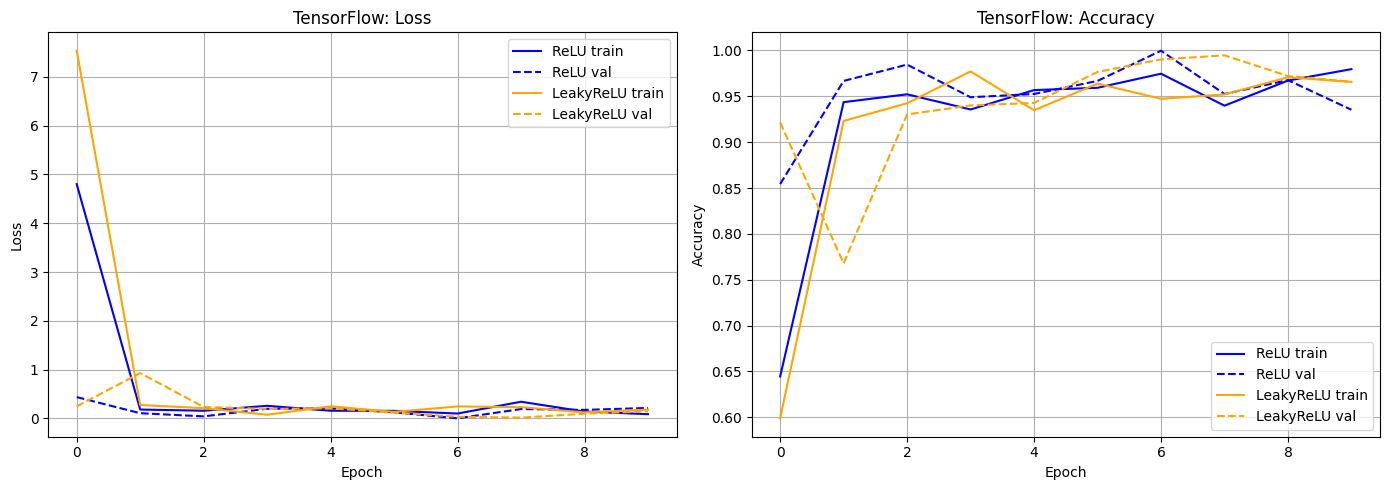

In [24]:
# Графіки TensorFlow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history_tf_relu.history['loss'], label='ReLU train', color='blue')
ax1.plot(history_tf_relu.history['val_loss'], label='ReLU val', color='blue', linestyle='--')
ax1.plot(history_tf_leaky.history['loss'], label='LeakyReLU train', color='orange')
ax1.plot(history_tf_leaky.history['val_loss'], label='LeakyReLU val', color='orange', linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('TensorFlow: Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history_tf_relu.history['accuracy'], label='ReLU train', color='blue')
ax2.plot(history_tf_relu.history['val_accuracy'], label='ReLU val', color='blue', linestyle='--')
ax2.plot(history_tf_leaky.history['accuracy'], label='LeakyReLU train', color='orange')
ax2.plot(history_tf_leaky.history['val_accuracy'], label='LeakyReLU val', color='orange', linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('TensorFlow: Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [25]:
 # Зведена таблиця результатів
print("=" * 70)
print("ПОРІВНЯННЯ ВСІХ 4 ВАРІАНТІВ")
print("=" * 70)
print(f"{'Варіант':<30} {'Test Loss':<12} {'Test Acc':<12} {'Час (сек)':<10}")
print("-" * 70)
print(f"{'PyTorch + ReLU':<30} {pt_relu_loss:<12.4f} {pt_relu_acc:<12.4f} {relu_time:<10.1f}")
print(f"{'PyTorch + LeakyReLU':<30} {pt_leaky_loss:<12.4f} {pt_leaky_acc:<12.4f} {leaky_time:<10.1f}")
print(f"{'TensorFlow + ReLU':<30} {tf_relu_loss:<12.4f} {tf_relu_acc:<12.4f} {tf_relu_time:<10.1f}")
print(f"{'TensorFlow + LeakyReLU':<30} {tf_leaky_loss:<12.4f} {tf_leaky_acc:<12.4f} {tf_leaky_time:<10.1f}")
print("=" * 70)

# Визначаємо найкращий
results = {
    'PyTorch + ReLU': pt_relu_acc,
    'PyTorch + LeakyReLU': pt_leaky_acc,
    'TensorFlow + ReLU': tf_relu_acc,
    'TensorFlow + LeakyReLU': tf_leaky_acc,
}
best = max(results, key=results.get)
print(f"\n🏆 Найкращий варіант: {best} ({results[best]:.4f})")

ПОРІВНЯННЯ ВСІХ 4 ВАРІАНТІВ
Варіант                        Test Loss    Test Acc     Час (сек) 
----------------------------------------------------------------------
PyTorch + ReLU                 0.0895       0.9703       548.7     
PyTorch + LeakyReLU            0.0120       0.9967       445.9     
TensorFlow + ReLU              0.2136       0.9353       105.3     
TensorFlow + LeakyReLU         0.1441       0.9659       103.0     

🏆 Найкращий варіант: PyTorch + LeakyReLU (0.9967)


======================================================================
ПОРІВНЯННЯ ВСІХ 4 ВАРІАНТІВ
======================================================================
Варіант                        Test Loss    Test Acc     Час (сек) 
----------------------------------------------------------------------
PyTorch + ReLU                 0.0895       0.9703       466.8     
PyTorch + LeakyReLU            0.0120       0.9967       380.7     
TensorFlow + ReLU              0.1477       0.9671       89.7      
TensorFlow + LeakyReLU         0.0520       0.9929       87.3      
======================================================================

🏆 Найкращий варіант: PyTorch + LeakyReLU (0.9967)

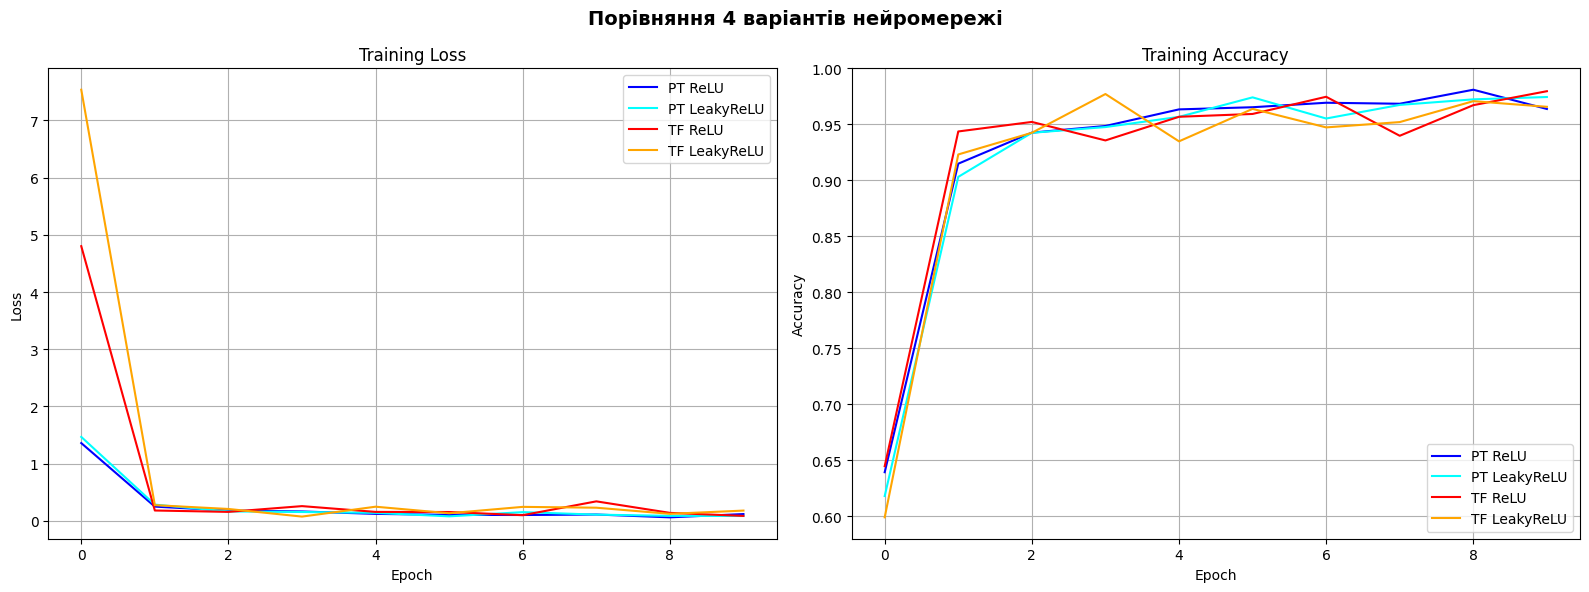

In [26]:
# Фінальний графік: всі 4 варіанти
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Порівняння 4 варіантів нейромережі', fontsize=14, fontweight='bold')

# Loss
ax1.plot(train_losses_relu, label='PT ReLU', color='blue')
ax1.plot(train_losses_leaky, label='PT LeakyReLU', color='cyan')
ax1.plot(history_tf_relu.history['loss'], label='TF ReLU', color='red')
ax1.plot(history_tf_leaky.history['loss'], label='TF LeakyReLU', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(train_accs_relu, label='PT ReLU', color='blue')
ax2.plot(train_accs_leaky, label='PT LeakyReLU', color='cyan')
ax2.plot(history_tf_relu.history['accuracy'], label='TF ReLU', color='red')
ax2.plot(history_tf_leaky.history['accuracy'], label='TF LeakyReLU', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()